In [ ]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy as np
import pandas as pd
import random

# classifier
from sklearn.linear_model import LogisticRegression

# Importing dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def load_data():
    data_df = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')
    data_df.to_csv('output_reviews_top.csv')
load_data()

In [ ]:
top_data_df = pd.read_csv('output_reviews_top.csv')
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['Unnamed: 0', 'URL', 'Text', 'Sentiment'], dtype='object')


# Data cleaning and analysing

Number of rows per star rating:
NEG    1000
POS     999
Name: Sentiment, dtype: int64


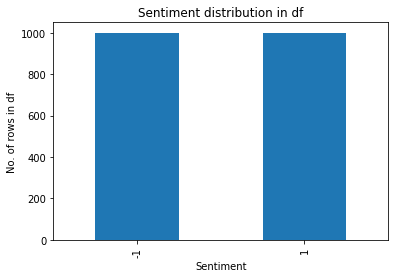

In [ ]:
import matplotlib.pyplot as plt 

print("Number of rows per star rating:")
print(top_data_df['Sentiment'].value_counts())

# Function to map stars to sentiment
def map_sentiment(sentiment):
    if sentiment == 'NEG':
        return -1
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['Sentiment_value'] = [map_sentiment(x) for x in top_data_df['Sentiment']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['Sentiment_value']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [ ]:
# Function to retrieve top few number of each category
def get_top_data(top_n):
    top_data_df_positive = top_data_df[top_data_df['Sentiment_value'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['Sentiment_value'] == -1].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small, top_data_df_positive, top_data_df_negative

top_data_df_small, pos_review, neg_review = get_top_data(999)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['Sentiment_value'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    999
-1    999
Name: Sentiment_value, dtype: int64


,Unnamed: 0,URL,Text,Sentiment,Sentiment_value
0,0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS,1
1,1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS,1
2,2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS,1
3,3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS,1
4,4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS,1
5,5,http://www.imdb.com/title/tt0347779/usercomments,A very good adaptation of the novel by amrita ...,POS,1
6,6,http://www.imdb.com/title/tt0095655/usercomments,"Ah, Moonwalker, I'm a huge Michael Jackson fan...",POS,1
7,7,http://www.imdb.com/title/tt0298131/usercomments,Although the beginning of the movie in New Yor...,POS,1
8,8,http://www.imdb.com/title/tt0088915/usercomments,"As many reviewers here have noted, the film ve...",POS,1
9,9,http://www.imdb.com/title/tt0828154/usercomments,"Bear in mind, any film (let alone documentary)...",POS,1


### Dataset Splitting

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_pos, X_test_pos, Y_train_pos, Y_test_pos = train_test_split(pos_review['Text'], 
                                                        pos_review['Sentiment_value'], 
                                                        random_state=15)

In [ ]:
X_train_neg, X_test_neg, Y_train_neg, Y_test_neg = train_test_split(neg_review['Text'], 
                                                        neg_review['Sentiment_value'], 
                                                        random_state=15)

In [ ]:
X_train_pos.shape, X_train_neg.shape

((749,), (749,))

In [ ]:
X_test_pos.shape, X_test_neg.shape

((250,), (250,))

# Doc to vector

In [ ]:
X_train_pos.to_csv(r'train-pos.txt', header=None, index=None, sep=' ', mode='a')
X_train_neg.to_csv(r'train-neg.txt', header=None, index=None, sep=' ', mode='a')
X_test_pos.to_csv(r'test-pos.txt', header=None, index=None, sep=' ', mode='a')
X_test_neg.to_csv(r'test-neg.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [ ]:
sources = {'test-neg.txt':'TEST_NEG', 'test-pos.txt':'TEST_POS', 'train-neg.txt':'TRAIN_NEG', 'train-pos.txt':'TRAIN_POS'}

sentences = LabeledLineSentence(sources)

### Training Model

In [ ]:
model = gensim.models.Doc2Vec(size=300, window=10, min_count=5, workers=11,alpha=0.025, min_alpha=0.025, iter=20)
model.build_vocab(sentences.to_array())
model.train(sentences.to_array(), epochs=model.iter, total_examples=model.corpus_count)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
model.most_similar('good')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('nice', 0.3883282542228699),
 ('fine', 0.37885838747024536),
 ('good.', 0.3753910958766937),
 ('decent', 0.3738258183002472),
 ('superb', 0.3530653715133667),
 ('good,', 0.34333837032318115),
 ('poor', 0.3426949381828308),
 ('more,', 0.32926416397094727),
 ('short', 0.32380664348602295),
 ('funny', 0.32072606682777405)]

In [ ]:
model['TRAIN_NEG_0']

In [ ]:
model.save('./imdb.d2v')

### Using doc2vec model

In [ ]:
model = Doc2Vec.load('./imdb.d2v')

In [ ]:
train_arrays = np.zeros((1498, 300))
train_labels = np.zeros(1498)

for i in range(749):
    prefix_train_pos = 'TRAIN_POS_' + str(i)
    prefix_train_neg = 'TRAIN_NEG_' + str(i)
    train_arrays[i] = model[prefix_train_pos]
    train_arrays[749 + i] = model[prefix_train_neg]
    train_labels[i] = 1
    train_labels[749 + i] = 0

In [ ]:
print(train_arrays)

[[ 0.48856449  0.60430449 -0.09253777 ... -0.38889179 -0.45873937
  -0.03055201]
 [ 0.86189646  0.18624328  0.70514441 ...  0.52049303 -0.01557526
   0.17981602]
 [ 0.22128329  0.04407672  0.52109158 ...  0.5626449  -0.20736666
   0.26234445]
 ...
 [ 0.07064036  0.3107408   0.17135926 ...  0.00692131  0.24868093
   0.21751943]
 [ 0.23267913  0.04838743  0.91032094 ...  0.16090974 -0.61993158
   0.55912155]
 [-0.10660066  0.31833789  0.25612915 ...  0.31709167  0.00705891
  -0.3756741 ]]


In [ ]:
print(train_labels)

[1. 1. 1. ... 0. 0. 0.]


In [ ]:
test_arrays = np.zeros((500, 300))
test_labels = np.zeros(500)

for i in range(250):
    prefix_test_pos = 'TEST_POS_' + str(i)
    prefix_test_neg = 'TEST_NEG_' + str(i)
    test_arrays[i] = model[prefix_test_pos]
    test_arrays[250 + i] = model[prefix_test_neg]
    test_labels[i] = 1
    test_labels[250 + i] = 0

### Using Logistic Regression classifier

In [ ]:
classifier = LogisticRegression(max_iter=300)
classifier.fit(train_arrays, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
classifier.score(test_arrays, test_labels)

0.822